In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
#pip install google-cloud-bigquery
#!pip install bigquery_magics

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [ ]:
import pandas as pd
import os
from google.colab import drive
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Data Loaded from Google cloud - big query

In [ ]:
#---------------- Full Data ----------------------------------#
# Admissions
%%bigquery admissions --project big-data-healthcare
SELECT * FROM `physionet-data.mimiciii_clinical.admissions`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# Patients
%%bigquery patients --project big-data-healthcare
SELECT * FROM `physionet-data.mimiciii_clinical.patients`


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# Diagnoses
%%bigquery diagnoses --project big-data-healthcare
SELECT * FROM `physionet-data.mimiciii_clinical.diagnoses_icd`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:

# ICD Diagnoses
%%bigquery icd_diagnoses --project big-data-healthcare
SELECT * FROM `physionet-data.mimiciii_clinical.d_icd_diagnoses`


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:

# Note Events
%%bigquery note_events --project big-data-healthcare
SELECT * FROM `physionet-data.mimiciii_notes.noteevents`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:

# Lab Events
%%bigquery labevents --project big-data-healthcare
SELECT * FROM `physionet-data.mimiciii_clinical.labevents`


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# Prescriptions
%%bigquery prescriptions --project big-data-healthcare
SELECT * FROM `physionet-data.mimiciii_clinical.prescriptions`


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
note_events.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,810034,6649,107611,2176-11-07,2176-11-07 09:39:00,NaT,Radiology,CT HEAD W/O CONTRAST,<NA>,<NA>,[**2176-11-7**] 9:39 AM\n CT HEAD W/O CONTRAST...
1,1260148,86645,<NA>,2166-02-01,2166-02-01 08:26:00,NaT,Radiology,CT HEAD W/O CONTRAST,<NA>,<NA>,[**2166-2-1**] 8:26 AM\n CT HEAD W/O CONTRAST ...
2,1221714,57815,186285,2122-11-26,2122-11-26 16:41:00,NaT,Radiology,MR HEAD W/O CONTRAST,<NA>,<NA>,[**2122-11-26**] 4:41 PM\n MR HEAD W/O CONTRAS...
3,1170392,91079,<NA>,2147-02-03,2147-02-03 09:39:00,NaT,Radiology,CT CHEST W/O CONTRAST,<NA>,<NA>,[**2147-2-3**] 9:39 AM\n CT CHEST W/O CONTRAST...
4,670617,80658,117314,2111-04-23,2111-04-23 05:09:00,2111-04-23 06:55:10,Nursing,Nursing Progress Note,16643,<NA>,Synopsis per prior nursing note:\n 57M with ...


Data Loading Finished!

In [ ]:
#---------------- Demo Data ----------------------------------#

#mount data
# # View current working directory
# print("Current Working Directory:", os.getcwd())

# Mount Google Drive
#drive.mount('/content/gdrive')

# Change working directory to your file position
#path = "/content/gdrive/My Drive/BD4H_project/data"
#os.chdir(path)

#csv location
#folder_path = 'HIDS-501-master/data/mimic-iii-demo/'


# load files function

#def load_csv(filename):
#    return pd.read_csv(os.path.join(filename))
##loading files
#admissions = load_csv('ADMISSIONS.csv')
#patients = load_csv('PATIENTS.csv')
#diagnoses = load_csv('DIAGNOSES_ICD.csv')
#icd_diagnoses = load_csv('D_ICD_DIAGNOSES.csv')
#note_events = load_csv('NOTEEVENTS.csv')
#labevents = load_csv('LABEVENTS.csv')
#prescriptions = load_csv('PRESCRIPTIONS.csv')


In [ ]:
#admissions.head()
#patients['SUBJECT_ID'].head()
admissions.rename(columns=lambda x: x.lower(), inplace=True)
patients.rename(columns=lambda x: x.lower(), inplace=True)
diagnoses.rename(columns=lambda x: x.lower(), inplace=True)
icd_diagnoses.rename(columns=lambda x: x.lower(), inplace=True)
note_events.rename(columns=lambda x: x.lower(), inplace=True)
labevents.rename(columns=lambda x: x.lower(), inplace=True)
prescriptions.rename(columns=lambda x: x.lower(), inplace=True)


In [ ]:
# Merge patients and admissions on subject_id
patient_data = pd.merge(patients, admissions, on='subject_id', how='inner')

# Select relevant columns
#patient_data = patient_data[['subject_id', 'gender', 'dob', 'admittime', 'dischtime', 'deathtime', 'ethnicity']]

# Convert date columns to datetime format
patient_data['dob'] = pd.to_datetime(patient_data['dob'])
patient_data['admittime'] = pd.to_datetime(patient_data['admittime'])
patient_data['dischtime'] = pd.to_datetime(patient_data['dischtime'])
patient_data['deathtime'] = pd.to_datetime(patient_data['deathtime'])

# Calculate age at admission (approximate)
#patient_data['age'] = (patient_data['admittime'] - patient_data['dob']).dt.days / 365.25


In [ ]:
patient_data.head()

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id_y,hadm_id,...,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,49,56,F,1804-01-02,2104-01-08,2104-01-08,2104-01-08,1,55,181711,...,Medicare,None,NOT SPECIFIED,None,WHITE,2104-01-01 23:59:00,2104-01-02 03:33:00,HEAD BLEED,1,1
1,17808,18848,F,2042-08-21,2128-01-08,2128-01-08,2128-01-08,1,22995,103662,...,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2127-12-15 15:47:00,2127-12-15 21:01:00,PNEUMONIA,1,1
2,17808,18848,F,2042-08-21,2128-01-08,2128-01-08,2128-01-08,1,22993,150678,...,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2125-01-18 11:29:00,2125-01-19 02:49:00,CHEST PAIN,0,1
3,17808,18848,F,2042-08-21,2128-01-08,2128-01-08,2128-01-08,1,22994,123774,...,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2127-05-26 06:37:00,2127-05-26 12:21:00,LOWER GI BLEED,0,1
4,36390,61056,F,2067-04-11,2152-01-08,2152-01-08,2152-01-08,1,46594,159036,...,Medicare,ENGL,NOT SPECIFIED,WIDOWED,OTHER,2151-09-23 11:36:00,2151-09-23 18:25:00,EXERTIONAL DYSPNEA,0,1


In [ ]:
patient_data.diagnosis.unique()

array(['HEAD BLEED', 'PNEUMONIA', 'CHEST PAIN', ...,
       'ATRIAL FRIBILLATION\\BILATERAL THORACOSCOPIC MINI MAZE PROCEDURE WITH LEFT ATRIAL APPENDAGE RESECTION ',
       'LIVER LESION\\RADIOFREQUENCY ABLATION LIVER LESION ** REMOTE WEST **',
       'PNA,CHF'], dtype=object)

In [ ]:
patient_data.diagnosis = patient_data.diagnosis.str.replace(";"," ").str.strip()
all_diagnosis_str = patient_data.diagnosis.str.cat(sep=" ")

subs = {"\\":" ", "-":"", "/":"", "?":""}
for s in subs.keys():
    all_diagnosis_str = all_diagnosis_str.replace(s, subs[s])

all_diagnosis = all_diagnosis_str.split(" ")

import collections
c = collections.Counter(all_diagnosis)
c.most_common(5)
top_6_keyword = sorted(c, key=c.get, reverse=True)[:6]
print(f"Top 5 most common diagnostic terms are: {top_6_keyword}")


Top 5 most common diagnostic terms are: ['NEWBORN', 'CORONARY', 'ARTERY', 'DISEASE', 'FAILURE', 'BLEED']


In [ ]:
for keyword in top_6_keyword:
    patient_data[keyword]=patient_data['diagnosis'].str.contains(keyword)

In [ ]:
patient_data.head()

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id_y,hadm_id,...,diagnosis,hospital_expire_flag,has_chartevents_data,NEWBORN,CORONARY,ARTERY,DISEASE,FAILURE,BLEED,age
0,49,56,F,1804-01-02,2104-01-08,2104-01-08,2104-01-08,1,55,181711,...,HEAD BLEED,1,1,False,False,False,False,False,True,300
1,17808,18848,F,2042-08-21,2128-01-08,2128-01-08,2128-01-08,1,22995,103662,...,PNEUMONIA,1,1,False,False,False,False,False,False,85
2,17808,18848,F,2042-08-21,2128-01-08,2128-01-08,2128-01-08,1,22993,150678,...,CHEST PAIN,0,1,False,False,False,False,False,False,82
3,17808,18848,F,2042-08-21,2128-01-08,2128-01-08,2128-01-08,1,22994,123774,...,LOWER GI BLEED,0,1,False,False,False,False,False,True,84
4,36390,61056,F,2067-04-11,2152-01-08,2152-01-08,2152-01-08,1,46594,159036,...,EXERTIONAL DYSPNEA,0,1,False,False,False,False,False,False,84


In [ ]:
diagnoses.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code
0,3113,256,108811,1,53240
1,3114,256,108811,2,41071
2,3115,256,108811,3,53560
3,3116,256,108811,4,40390
4,3117,256,108811,5,5859


In [ ]:
diagnoses['icd9_code'].unique()[:10]

array(['53240', '41071', '53560', '40390', '5859', '04186', '41401',
       '2724', '496', '42731'], dtype=object)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each ICD-9 code
icd_code_counts = diagnoses['icd9_code'].value_counts().reset_index()
icd_code_counts.columns = ['icd9_code', 'count']
icd_code_counts.columns = ['ICD9_Code', 'Count']

# Sort the DataFrame by the count in descending order
icd_code_counts = icd_code_counts.sort_values(by='Count', ascending=False)
icd_code_counts

,ICD9_Code,Count
0,4019,20703
1,4280,13111
2,42731,12891
3,41401,12429
4,5849,9119
...,...,...
5978,31234,1
5977,V4363,1
5976,2778,1
5975,7601,1


<ipython-input-26-0850157c018e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=icd_code_counts_top, x='Count', y='ICD9_Code', palette="viridis")


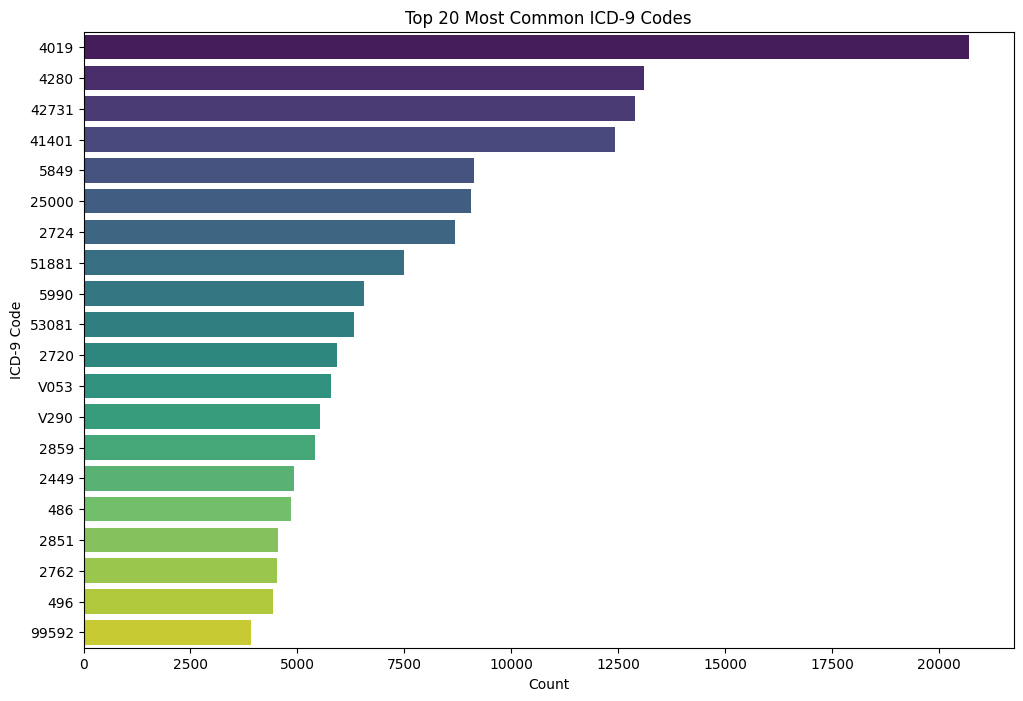

In [ ]:
top_n = 20
icd_code_counts_top = icd_code_counts.head(top_n)

# Plot the counts of each ICD-9 code
plt.figure(figsize=(12, 8))
sns.barplot(data=icd_code_counts_top, x='Count', y='ICD9_Code', palette="viridis")
plt.title(f"Top {top_n} Most Common ICD-9 Codes")
plt.xlabel("Count")
plt.ylabel("ICD-9 Code")
plt.show()

In [ ]:
## Preprocessing Continued

# Fill missing numerical columns with the mean
numerical_columns = patient_data.select_dtypes(include=[np.number]).columns
patient_data[numerical_columns] = patient_data[numerical_columns].fillna(patient_data[numerical_columns].mean())

# Fill categorical columns with a placeholder value 'Unknown'
categorical_columns = patient_data.select_dtypes(exclude=[np.number]).columns
patient_data[categorical_columns] = patient_data[categorical_columns].fillna('Unknown')


In [ ]:
## Feature Engineering

# Age at admission
patient_data['age_at_admission'] = (
    (patient_data['admittime'].dt.year - patient_data['dob'].dt.year) -
    ((patient_data['admittime'].dt.month < patient_data['dob'].dt.month) |
     ((patient_data['admittime'].dt.month == patient_data['dob'].dt.month) & (patient_data['admittime'].dt.day < patient_data['dob'].dt.day))
    ).astype(int)
)

# Length of stay
patient_data['length_of_stay'] = (patient_data['dischtime'] - patient_data['admittime']).dt.days

# One-hot encode categorical variables and add to dataset
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_columns_to_encode = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']

for column in categorical_columns_to_encode:
    encoded = encoder.fit_transform(patient_data[[column]])
    encoded_df = pd.DataFrame(encoded, columns=encoder.categories_[0])
    patient_data = pd.concat([patient_data, encoded_df], axis=1)

# Step 5: Vectorize diagnosis terms using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)  # Limit to 100 features for simplicity
diagnosis_matrix = vectorizer.fit_transform(patient_data['diagnosis'])

# Convert the sparse matrix to a dense DataFrame and concatenate with patient data
diagnosis_df = pd.DataFrame(diagnosis_matrix.toarray(), columns=vectorizer.get_feature_names_out())
patient_data = pd.concat([patient_data, diagnosis_df], axis=1)

# Step 6: Aggregating data (e.g., number of diagnoses per patient)
patient_data['num_diagnoses'] = patient_data['diagnosis'].apply(lambda x: len(x.split(" ")))

# Step 7: Inspecting the final dataframe
print(patient_data.head())

   row_id_x  subject_id gender        dob                  dod  \
0        49          56      F 1804-01-02  2104-01-08 00:00:00   
1     17808       18848      F 2042-08-21  2128-01-08 00:00:00   
2     17808       18848      F 2042-08-21  2128-01-08 00:00:00   
3     17808       18848      F 2042-08-21  2128-01-08 00:00:00   
4     36390       61056      F 2067-04-11  2152-01-08 00:00:00   

              dod_hosp              dod_ssn  expire_flag  row_id_y  hadm_id  \
0  2104-01-08 00:00:00  2104-01-08 00:00:00            1        55   181711   
1  2128-01-08 00:00:00  2128-01-08 00:00:00            1     22995   103662   
2  2128-01-08 00:00:00  2128-01-08 00:00:00            1     22993   150678   
3  2128-01-08 00:00:00  2128-01-08 00:00:00            1     22994   123774   
4  2152-01-08 00:00:00  2152-01-08 00:00:00            1     46594   159036   

   ... transient trauma tumor unstable upper urinary valve vehicle with  \
0  ...       0.0    0.0   0.0      0.0   0.0     0.0 

****Patient Similarity Scores****

In [ ]:
record_counts = patient_data['subject_id'].value_counts().sort_values(ascending=False)
record_counts

patient_data[patient_data['subject_id'] == 41976]
pd.set_option('display.max_columns', None)
#print(patient_data.describe())
#patient_data[['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender','age_at_admission','length_of_stay','num_diagnoses','hadm_id','subject_id','row_id_x','row_id_y','tumor','unstable','DEAD/EXPIRE']]

In [ ]:
import gc
gc.collect()

In [ ]:
patients_data_sim = pd.merge(patient_data[['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender','age_at_admission','length_of_stay','num_diagnoses','hadm_id','subject_id','row_id_x','row_id_y','tumor','unstable','DEAD/EXPIRED','hospital_expire_flag']], admissions[['hadm_id', 'diagnosis']], on='hadm_id', how='left', suffixes=('','_admissions'))

#patients_data_sim.head()
available_categorical_features = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']
categorical_features = [feature for feature in available_categorical_features if feature in patients_data_sim.columns]
numerical_features = ['age_at_admission','length_of_stay','num_diagnoses']
features = ['age_at_admission', 'length_of_stay', 'num_diagnoses'] + categorical_features


# Step 4: Create a ColumnTransformer to handle the categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])
X = patients_data_sim[features]
y = patients_data_sim['hospital_expire_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
#similarity_matrix = cosine_similarity(X_train_processed)

## Print similarity matrix (consider limiting the size for large datasets)
#print("Similarity Matrix (truncated):")
#print(similarity_matrix[:5, :5])  # Print the first 5 rows and columns

# Calculate and print cosine similarity for specific patients
#patient_index_1 = 0  # Index of the first patient
#patient_index_2 = 1  # Index of the second patient
#cosine_sim = cosine_similarity(X_train_processed[patient_index_1].reshape(1, -1),
#                               X_train_processed[patient_index_2].reshape(1, -1))[0][0]
#print(f"Cosine similarity between patient {patient_index_1} and {patient_index_2}: {cosine_sim}")

# Plot heatmap of similarity matrix (consider limiting size for large datasets)
#plt.figure(figsize=(15, 12))
#sns.heatmap(similarity_matrix[:20, :20], annot=True, cmap="viridis", fmt=".2f")  # Limit to 20x20 for visualization
#plt.title("Similarity Matrix Heatmap")
#plt.show()



In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Aggregate data per patient by grouping by 'subject_id'
patient_data_agg = patients_data_sim.groupby('subject_id').agg({
    'age_at_admission': 'mean',  # Average age across admissions
    'length_of_stay': 'mean',    # Average length of stay across admissions
    'num_diagnoses': 'max',      # Use max diagnoses count (or any relevant choice)
    **{col: lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0] for col in categorical_features}
    #**{col: 'first' for col in categorical_features}  # Take the first value of each categorical feature (or mode)
}).reset_index()

patient_data_agg = patient_data_agg.sample(n=1000, random_state=42)

# Define features for patient-level similarity
X = patient_data_agg[features]
y = patient_data_agg['hospital_expire_flag'] if 'hospital_expire_flag' in patient_data_agg.columns else None

# Step 2: Apply transformations to numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=True, handle_unknown='ignore'), categorical_features)
    ])

# Fit and transform preprocessor
X_processed = preprocessor.fit_transform(X)

# Step 3: Compute similarity matrix
similarity_matrix = cosine_similarity(X_processed)

# Step 4: Visualize similarity matrix (truncated for readability)
print("Similarity Matrix (truncated):")
print(similarity_matrix[:5, :5])

# Optional: Plot heatmap for the first few patients' similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_matrix[:20, :20], annot=True, cmap="viridis", fmt=".2f")  # Limited to 20x20 for visualization
plt.title("Patient-Level Similarity Matrix Heatmap")
plt.show()


In [ ]:
# prompt: clean variables that are taking ram

import gc
gc.collect()
# Delete large variables
del X
del y
del X_train
del X_test
del y_train
del y_test
del X_train_processed
del X_test_processed
del patient_data_agg
del X_processed
del similarity_matrix


# Force garbage collection
gc.collect()

NameError: name 'X' is not defined

*** Modeling for Diagnostic prediction for Clinical Decision Support***

In [ ]:
#len(admissions)


In [ ]:
## Build a model for 4019 only

# Step 1: Filter for ICD-9 Code 4019 (Hypertension, unspecified)
patients_with_4019 = diagnoses[diagnoses['icd9_code'] == '4019']

# Merge with preprocessed patient data to get relevant patient information
# -- changed: Merge on subject_id to keep 'hadm_id' from patients_with_4019
patients_4019_data = pd.merge(patients_with_4019, patient_data, on='subject_id', how='inner', suffixes=('','_patient_data'))
patients_4019_data.head()

# Extract discharge diagnosis from ADMISSIONS (discharge diagnosis can be found in the 'diagnosis' field in ADMISSIONS)
# patients_4019_data should now have 'hadm_id' for the merge
patients_4019_data = pd.merge(patients_4019_data, admissions[['hadm_id', 'diagnosis']], on='hadm_id', how='left', suffixes=('','_admissions'))
patients_4019_data.head()

#--- for memory -----#
#patients_4019_data = patients_4019_data.sample(n=10000, random_state=42)

# Step 2: Encode the discharge diagnosis
# We will use LabelEncoder to convert the discharge diagnosis into numeric labels
label_encoder = LabelEncoder()
patients_4019_data['diagnosis_encoded'] = label_encoder.fit_transform(patients_4019_data['diagnosis'])

# Step 3: Prepare the features for the model (we’ll exclude the 'diagnosis' and 'diagnosis_encoded' columns)
# features = ['age_at_admission', 'length_of_stay', 'num_diagnoses'] + \
#            list(patients_4019_data.columns[patients_4019_data.columns.str.startswith('admission_type')])

# # Separate categorical and numerical features
# categorical_features = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']
# numerical_features = [feature for feature in features if feature not in categorical_features]

# Check available categorical columns in the dataframe
available_categorical_features = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']

# Only keep columns that exist in the dataframe
categorical_features = [feature for feature in available_categorical_features if feature in patients_4019_data.columns]

#Added by Umair
numerical_features = ['age_at_admission','length_of_stay','num_diagnoses']

# Prepare features for model (updated to include only existing columns)
features = ['age_at_admission', 'length_of_stay', 'num_diagnoses'] + categorical_features


# Step 4: Create a ColumnTransformer to handle the categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=True, handle_unknown='ignore'), categorical_features)
    ])

# Step 5: Create a pipeline to preprocess the data and train the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Step 6: Split the data into training and testing sets (80% training, 20% testing)
X = patients_4019_data[features]

from sklearn.decomposition import PCA
X_transformed = preprocessor.fit_transform(X)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_transformed)

y = patients_4019_data['diagnosis_encoded']
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Step 7: Train the Random Forest classifier using the pipeline
model_pipeline.fit(X_train, y_train)

# Step 8: Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Step 9: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print(classification_report(y_test, y_pred))

# Optional: Save the preprocessed data and model for later use
# patients_4019_data.to_csv('preprocessed_patient_data_4019.csv', index=False)
# joblib.dump(model_pipeline, 'random_forest_model_4019.pkl')

****Single diagnosis Classification****

In [ ]:
#patients_4019_data['diagnosis_encoded'].nunique()
#diagnoses[diagnoses['icd9_code'] == '4019']
diagnoses
patients_with_4019 = diagnoses[diagnoses['icd9_code'] == '4019']
patients_diagnoses_data = pd.merge(patient_data,patients_with_4019, on='subject_id', how='left', suffixes=('','_patient_data'))
#patients_diagnoses_admission_data = pd.merge(patients_diagnoses_data, admissions[['hadm_id', 'diagnosis']], on='hadm_id', how='left', suffixes=('','_admissions'))

In [ ]:
#patients_diagnoses_data.head()
patients_diagnoses_data['icd9_code_label'] = patients_diagnoses_data['icd9_code'].fillna(0).replace('4019', 1)
patients_diagnoses_data['icd9_code_label'].unique()

<ipython-input-49-8936575c1f0a>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  patients_diagnoses_data['icd9_code_label'] = patients_diagnoses_data['icd9_code'].fillna(0).replace('4019', 1)


array([0, 1])

In [ ]:
patients_diagnoses_admission_data = pd.merge(patients_diagnoses_data, admissions[['row_id', 'subject_id','hadm_id','admittime','admission_type','admission_location','insurance','hospital_expire_flag','hospital_expire_flag']], on='hadm_id', how='left', suffixes=('','_admissions'))

In [ ]:
admissions.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data'],
      dtype='object')

In [ ]:
modeling_df = patients_diagnoses_admission_data[['SEPSIS', 'FAILURE', 'PNEUMONIA', 'TELEMETRY', 'BLEED', 'ACUTE','admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender','age_at_admission',
                                                 'length_of_stay','num_diagnoses','hospital_expire_flag','SINGLE','Medicaid','Medicare','icd9_code_label']]

In [ ]:
available_categorical_features = ['SEPSIS', 'FAILURE', 'PNEUMONIA', 'TELEMETRY', 'BLEED', 'ACUTE','admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']
categorical_features = [feature for feature in available_categorical_features if feature in modeling_df.columns]
numerical_features = ['age_at_admission','length_of_stay','num_diagnoses']


# Prepare features for model (updated to include only existing columns)
features = ['age_at_admission', 'length_of_stay', 'num_diagnoses'] + categorical_features


# Step 4: Create a ColumnTransformer to handle the categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Step 5: Create a pipeline to preprocess the data and train the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Step 6: Split the data into training and testing sets (80% training, 20% testing)
X = modeling_df[features]
y = modeling_df['icd9_code_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train the Random Forest classifier using the pipeline
model_pipeline.fit(X_train, y_train)

# Step 8: Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Step 9: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print(classification_report(y_test, y_pred))


Model accuracy: 87.69%
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.94      0.90      0.92        50

    accuracy                           0.88        65
   macro avg       0.82      0.85      0.83        65
weighted avg       0.88      0.88      0.88        65



In [ ]:
import gc
# Force garbage collection
gc.collect()
#patient_data['gender'].head()
diagnoses.head()
#patients_with_4019 = diagnoses[diagnoses['icd9_code'] == '4019']
patient_data['dob'].head()
# Merge with preprocessed patient data to get relevant patient information
# -- changed: Merge on subject_id to keep 'hadm_id' from patients_with_4019
#patients_4019_data = pd.merge(patients_with_4019, patient_data, on='subject_id', how='inner', suffixes=('','_patient_data'))
patient_data['admittime'].head()

,admittime
0,2104-01-02 02:01:00
1,2127-12-15 19:27:00
2,2125-01-19 01:47:00
3,2127-05-26 10:49:00
4,2151-09-23 13:40:00


Replicated Paper steps - Flowchart

In [ ]:
#patient_data['subject_id'].nunique()
patient_data['hadm_id'].nunique()
#hadm_id

58976

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# --- Step 1: Patients Feature Vectors Generation ---
# Prepare feature vectors from multiple tables
patient_data['admittime'] = pd.to_datetime(patient_data['admittime'])
patient_data['dob'] = pd.to_datetime(patient_data['dob'])

# Generate Age at Admission
patient_data['age'] = (patient_data['admittime'] - patient_data['dob']).dt.days // 365

# Filter relevant data
features = ['subject_id', 'hadm_id', 'admission_type', 'age', 'insurance', 'marital_status', 'ethnicity', 'gender']
patient_features = patient_data[features].dropna()



#patients_data_sim = pd.merge(patient_data[['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender','age_at_admission','length_of_stay','num_diagnoses','hadm_id','subject_id','row_id_x','row_id_y','tumor','unstable','DEAD/EXPIRED','hospital_expire_flag']], admissions[['hadm_id', 'diagnosis']], on='hadm_id', how='left', suffixes=('','_admissions'))
#available_categorical_features = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']
#categorical_features = [feature for feature in available_categorical_features if feature in patients_data_sim.columns]
#numerical_features = ['age_at_admission','length_of_stay','num_diagnoses']
#features = ['age_at_admission', 'length_of_stay', 'num_diagnoses'] + categorical_features


#patient_data_agg = patients_data_sim.groupby('subject_id').agg({
#    'age_at_admission': 'mean',  # Average age across admissions
#    'length_of_stay': 'mean',    # Average length of stay across admissions
#    'num_diagnoses': 'max',      # Use max diagnoses count (or any relevant choice)
#    **{col: lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0] for col in categorical_features}
#    #**{col: 'first' for col in categorical_features}  # Take the first value of each categorical feature (or mode)
#}).reset_index()

#patient_data_agg = patient_data_agg.sample(n=1000, random_state=42)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

# Step 1: Filter patient_data based on hadm_id that exist in note_events
filtered_patient_data = patient_data[patient_data['hadm_id'].isin(note_events['hadm_id'])]

# Step 2: Randomly sample 1000 patient_ids from filtered_patient_data
sampled_patient_data = filtered_patient_data.sample(n=1000, random_state=42)

sampled_patient_data = pd.merge(sampled_patient_data, diagnoses[['hadm_id', 'icd9_code']], on='hadm_id', how='left')
#print(sampled_patient_data.head())
# Step 3: Filter note_events based on sampled patient_ids (hadm_id)
filtered_notes = note_events[note_events['hadm_id'].isin(sampled_patient_data['hadm_id'])]

# Step 4: Prepare patient feature vectors
# Generate Age at Admission
sampled_patient_data['admittime'] = pd.to_datetime(sampled_patient_data['admittime'])
sampled_patient_data['dob'] = pd.to_datetime(sampled_patient_data['dob'])
sampled_patient_data['age'] = (sampled_patient_data['admittime'] - sampled_patient_data['dob']).dt.days // 365

# Select relevant features
#features = ['subject_id', 'hadm_id', 'admission_type', 'age', 'insurance', 'marital_status', 'ethnicity', 'gender']
features = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status','ethnicity', 'religion', 'language','age', 'gender','age_at_admission','length_of_stay','num_diagnoses','tumor','unstable','DEAD/EXPIRED','hospital_expire_flag']
patient_features = sampled_patient_data[features].dropna()

# One-hot encoding categorical data
categorical_cols = ['admission_type', 'insurance', 'marital_status', 'ethnicity', 'gender']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(patient_features[categorical_cols])

# Combine with age (numerical feature)
#'num_diagnoses','length_of_stay'
patient_features_encoded = np.hstack([patient_features[['age']].values,patient_features[['num_diagnoses']].values,patient_features[['length_of_stay']].values, encoded_features])

# Step 5: Tokenize and preprocess clinical notes for the subset of notes
max_vocab_size = 10000  # Maximum number of words in the tokenizer vocabulary
max_sequence_length = 200  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(filtered_notes['text'].values)

# Convert texts to sequences and pad them
sequences = tokenizer.texts_to_sequences(filtered_notes['text'].values)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Step 6: Define the seq2seq embedding model
embedding_dim = 128  # Dimensionality of the embedding space

input_seq = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim)(input_seq)
lstm_layer = LSTM(128)(embedding_layer)
dense_layer = Dense(128, activation='relu')(lstm_layer)
embedding_model = Model(inputs=input_seq, outputs=dense_layer)

# Step 7: Generate embeddings for clinical notes
batch_size = 32  # Adjust this based on available memory

note_embeddings = []
for start in range(0, len(padded_sequences), batch_size):
    end = min(start + batch_size, len(padded_sequences))
    batch = padded_sequences[start:end]
    batch_embeddings = embedding_model.predict(batch)
    note_embeddings.append(batch_embeddings)

# Convert list of batches to a numpy array
note_embeddings = np.vstack(note_embeddings)

# Add embeddings to the notes DataFrame
note_events_embed = filtered_notes.copy()  # Ensure working with a copy of the filtered notes
note_events_embed['embedding'] = list(note_embeddings)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/

In [ ]:
#len(sampled_patient_data)
#note_events_embed
#averaged_embeddings

In [ ]:
# Step 8: Merge patient features with the embeddings
# Ensure both patient_features and note_events_embed are using the same hadm_id values
averaged_embeddings = note_events_embed.groupby(['hadm_id'])['embedding'].apply(lambda x: np.mean(np.vstack(x), axis=0))
averaged_embeddings = averaged_embeddings.reset_index()
averaged_embeddings
patient_embeddings = pd.merge(sampled_patient_data, averaged_embeddings[['hadm_id', 'embedding']],
                              left_on='hadm_id', right_on='hadm_id', how='left')

#len(patient_embeddings)
patient_embeddings.head()

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id_y,hadm_id,...,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,age,icd9_code,embedding
0,16769,17735,F,2100-11-26,NaT,NaT,NaT,0,21668,152138,...,MARRIED,ASIAN - VIETNAMESE,2169-09-18 19:06:00,2169-09-18 22:17:00,ANEMIA,0,1,68,41071,"[0.0044380794, 0.009727841, 0.004649435, 0.000..."
1,16769,17735,F,2100-11-26,NaT,NaT,NaT,0,21668,152138,...,MARRIED,ASIAN - VIETNAMESE,2169-09-18 19:06:00,2169-09-18 22:17:00,ANEMIA,0,1,68,4280,"[0.0044380794, 0.009727841, 0.004649435, 0.000..."
2,16769,17735,F,2100-11-26,NaT,NaT,NaT,0,21668,152138,...,MARRIED,ASIAN - VIETNAMESE,2169-09-18 19:06:00,2169-09-18 22:17:00,ANEMIA,0,1,68,53200,"[0.0044380794, 0.009727841, 0.004649435, 0.000..."
3,16769,17735,F,2100-11-26,NaT,NaT,NaT,0,21668,152138,...,MARRIED,ASIAN - VIETNAMESE,2169-09-18 19:06:00,2169-09-18 22:17:00,ANEMIA,0,1,68,2851,"[0.0044380794, 0.009727841, 0.004649435, 0.000..."
4,16769,17735,F,2100-11-26,NaT,NaT,NaT,0,21668,152138,...,MARRIED,ASIAN - VIETNAMESE,2169-09-18 19:06:00,2169-09-18 22:17:00,ANEMIA,0,1,68,41401,"[0.0044380794, 0.009727841, 0.004649435, 0.000..."


In [ ]:
# --- Step 8: One-hot encode categorical patient features ---
categorical_cols = ['admission_type', 'insurance', 'marital_status', 'ethnicity', 'gender']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(patient_embeddings[categorical_cols])

# Combine the numerical and categorical features with the embeddings
patient_features_encoded = np.hstack([patient_embeddings[['age']].values, encoded_features, np.vstack(patient_embeddings['embedding'].values)])

# --- Step 9: Check final merged data ---
print("Shape of final features:", patient_features_encoded.shape)

Shape of final features: (11240, 172)


In [ ]:
# --- Step 2: Semantic Corpus Generation ---
# BioSentVec takes way too much RAM, the model file itself if 20GB. Instead, using clinicalBERT, which has been fine-tuned on MIMIC-III clinical notes

from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")


def compute_avg_embeddings(df, tokenizer, model, batch_size=64):
    """
    Compute averaged embeddings for each `hadm_id` by averaging embeddings of all associated notes.
    Args:
        df (DataFrame): DataFrame with 'hadm_id' and 'text_column'.
        tokenizer: ClinicalBERT tokenizer.
        model: ClinicalBERT model.
        batch_size (int): Number of rows to process per batch.
    Returns:
        DataFrame: DataFrame with `hadm_id` and averaged embeddings.
    """
    embeddings = {}
    total_rows = len(df)

    # Move model to GPU if available
    if torch.cuda.is_available():
        model = model.to("cuda")

    for i in range(0, total_rows, batch_size):
        batch_texts = df['text'].iloc[i:i+batch_size].tolist()
        batch_hadm_ids = df['hadm_id'].iloc[i:i+batch_size].tolist()

        # Tokenize and move inputs to GPU if available
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, max_length=512, padding=True)
        if torch.cuda.is_available():
            inputs = {key: val.to("cuda") for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Extract [CLS] token embeddings
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Shape: (batch_size, 768)

        # Store embeddings by `hadm_id`
        for hadm_id, embedding in zip(batch_hadm_ids, cls_embeddings):
            if hadm_id not in embeddings:
                embeddings[hadm_id] = []
            embeddings[hadm_id].append(embedding)

    # Average embeddings for each `hadm_id`
    averaged_data = []
    for hadm_id, vectors in embeddings.items():
        avg_embedding = np.mean(np.vstack(vectors), axis=0)  # Compute mean embedding
        averaged_data.append({'hadm_id': hadm_id, 'avg_embedding': avg_embedding})

    # Create a new DataFrame with `hadm_id` and averaged embeddings
    return pd.DataFrame(averaged_data)

# Compute averaged embeddings
bert_embeddings = compute_avg_embeddings(filtered_notes, tokenizer, model, batch_size=64)


averaged_embeddings2 = bert_embeddings.groupby(['hadm_id'])['avg_embedding'].apply(lambda x: np.mean(np.vstack(x), axis=0))
averaged_embeddings2 = averaged_embeddings2.reset_index()
averaged_embeddings2
patient_embeddings2 = pd.merge(sampled_patient_data, averaged_embeddings2[['hadm_id', 'avg_embedding']],
                              left_on='hadm_id', right_on='hadm_id', how='left')

#len(patient_embeddings)
patient_embeddings2.head()



#from gensim.models.keyedvectors import KeyedVectors

# Load pre-trained BioSentVec model (ensure you have it downloaded)
#biosentvec = KeyedVectors.load_word2vec_format('BioSentVec_PubMed_MIMICIII-bigram_d700.bin', binary=True)

# Generate embeddings for clinical notes
#def get_sentence_embedding(sentence, model):
#    return np.mean([model[word] for word in sentence.split() if word in model], axis=0)

# Generate embeddings for discharge summaries in note_events
#note_events['embedding'] = note_events['text'].apply(lambda x: get_sentence_embedding(x, biosentvec))

# Combine patient features with embeddings
#patient_embeddings = pd.merge(patient_features, note_events[['hadm_id', 'embedding']], on='hadm_id', how='left')
#final_features = np.hstack([patient_features_encoded, np.vstack(patient_embeddings['embedding'].values)])
# patient_features_encoded.shape
# sampled_patient_data.shape
#diagnoses.head()

(11240, 28)

In [ ]:
# --- Step 3: Neural Network Building and Training ---
# Define target (diagnosis codes from `diagnoses`)
label_encoder = LabelEncoder()
#diagnoses_df = diagnoses.copy()
patient_embeddings['label'] = label_encoder.fit_transform(patient_embeddings['icd9_code'])
target = patient_embeddings['label']  #pd.merge(sampled_patient_data[['hadm_id']], diagnoses_df[['hadm_id', 'label']], on='hadm_id', how='left')['label']
#print(len(target))
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(patient_features_encoded, target, test_size=0.2, random_state=42)

# Build Neural Network
model = Sequential([
    Dense(256, activation='relu', input_dim=patient_features_encoded.shape[1]),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer for multi-class classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0196 - loss: 7.2420 - val_accuracy: 0.0360 - val_loss: 6.4900
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0310 - loss: 6.3738 - val_accuracy: 0.0383 - val_loss: 6.3749
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0395 - loss: 6.2363 - val_accuracy: 0.0383 - val_loss: 6.3949
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0352 - loss: 6.2178 - val_accuracy: 0.0356 - val_loss: 6.4162
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0352 - loss: 6.1705 - val_accuracy: 0.0383 - val_loss: 6.4226
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.0380 - loss: 6.1512 - val_accuracy: 0.0378 - val_loss: 6.4405
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0407 - loss: 6.0913 - val_accuracy: 0.0356 - val_loss: 6.4605
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0391 - loss: 6.0827 - val_accuracy: 0.0347 - v

In [ ]:
#patient_embeddings

In [ ]:

# --- Step 4: Similarity Profiles Construction ---
# Compute cosine similarity
cosine_sim = cosine_similarity(patient_features_encoded)
len(cosine_sim)

11240

In [ ]:
from collections import Counter
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming `patient_features_encoded` is the matrix containing all encoded patient features
# Cosine similarity matrix computation for all patients
similarity_matrix = cosine_similarity(X_test)

def get_top_k_similarities(idx, k):
    """
    For a given patient, get the top-k most similar patients based on cosine similarity.
    Args:
        idx (int): The index of the patient in the embeddings.
        k (int): The number of top similar patients to return.
    Returns:
        List of indices of the top-k most similar patients.
    """
    similarities = similarity_matrix[idx]  # Get similarity scores with all patients
    # Sort by similarity (descending order), excluding the patient itself (same index)
    similar_indices = similarities.argsort()[-k-1:-1][::-1]  # Exclude itself by -1
    return similar_indices

def predict_with_similarity(idx, k, embeddings, labels):
    """
    Predict the diagnosis for a given test patient based on the similarity profiles.
    Args:
        idx (int): The index of the test patient.
        k (int): The number of top similar patients to consider.
        embeddings (numpy array): The patient embeddings matrix.
        labels (numpy array): The true diagnoses or labels.
    Returns:
        Predicted diagnosis (the most common label among the top-k similar patients).
    """
    similar_indices = get_top_k_similarities(idx, k)
    similar_labels = labels[similar_indices]  # Get the labels for the most similar patients

    # Predict the most common diagnosis among the top-k most similar patients
    predicted_diagnosis = Counter(similar_labels).most_common(1)[0][0]
    return predicted_diagnosis

# --- Step 9: Evaluate Precision, Recall, F1-Score ---
# Assuming `X_test` and `y_test` are your test set features and labels
for k in [3, 5, 10]:
    print(f"\nEvaluating with k={k}:")

    # Use `patient_features_encoded` directly as it's a NumPy array
    y_pred_k = [predict_with_similarity(idx, k, X_test, y_test.values) for idx in range(len(X_test))]

    # Evaluate the model using precision, recall, and F1-score (macro average)
    precision_k = precision_score(y_test, y_pred_k, average='macro')
    recall_k = recall_score(y_test, y_pred_k, average='macro')
    f1_k = f1_score(y_test, y_pred_k, average='macro')

    print(f"Precision: {precision_k:.2f}, Recall: {recall_k:.2f}, F1-Score: {f1_k:.2f}")


NameError: name 'X_test' is not defined

In [ ]:
patients_data_sim = pd.merge(patient_data[['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender','age_at_admission','length_of_stay','num_diagnoses','hadm_id','subject_id','row_id_x','row_id_y','tumor','unstable','DEAD/EXPIRED','hospital_expire_flag']], admissions[['hadm_id', 'diagnosis']], on='hadm_id', how='left', suffixes=('','_admissions'))

#patients_data_sim.head()
available_categorical_features = ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'marital_status', 'religion', 'language', 'gender']
categorical_features = [feature for feature in available_categorical_features if feature in patients_data_sim.columns]
numerical_features = ['age_at_admission','length_of_stay','num_diagnoses']
features = ['age_at_admission', 'length_of_stay', 'num_diagnoses'] + categorical_features


patient_data_agg = patients_data_sim.groupby('subject_id').agg({
    'age_at_admission': 'mean',  # Average age across admissions
    'length_of_stay': 'mean',    # Average length of stay across admissions
    'num_diagnoses': 'max',      # Use max diagnoses count (or any relevant choice)
    **{col: lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0] for col in categorical_features}
    #**{col: 'first' for col in categorical_features}  # Take the first value of each categorical feature (or mode)
}).reset_index()

patient_data_agg = patient_data_agg.sample(n=1000, random_state=42)


# Step 4: Create a ColumnTransformer to handle the categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])
X = patients_data_sim[features]
y = patients_data_sim['hospital_expire_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Aggregate data per patient by grouping by 'subject_id'
patient_data_agg = patients_data_sim.groupby('subject_id').agg({
    'age_at_admission': 'mean',  # Average age across admissions
    'length_of_stay': 'mean',    # Average length of stay across admissions
    'num_diagnoses': 'max',      # Use max diagnoses count (or any relevant choice)
    **{col: lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0] for col in categorical_features}
    #**{col: 'first' for col in categorical_features}  # Take the first value of each categorical feature (or mode)
}).reset_index()

patient_data_agg = patient_data_agg.sample(n=1000, random_state=42)
